# Transformations

During training we will be using the albumenattions module to transform the input image, this notebook shows how it is done

In [1]:
import pandas as pd
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_from_albumentations
import torch
import ast
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

# Helper Function

In [2]:
def apply_ast(string):
    try:
        return(ast.literal_eval(string))
    except:
        return(None)

In [3]:
def dicom2array(path: str, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    return data.astype(np.float32)

In [4]:
train = pd.read_csv('../input/id_s.csv')
train['boxes'] = train.boxes.apply(apply_ast)

In [5]:
train.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape,fold
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...,4256,3488,"(3488, 4256)",0
1,000c3a3f293f,None,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...,4256,3488,"(3488, 4256)",0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...,4256,3488,"(3488, 4256)",4
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...,4256,3488,"(3488, 4256)",4
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...,4256,3488,"(3488, 4256)",2


Let's choose a test subject.

# T1

In [6]:
t1 = train.loc[2, :]
t1

id                                                               0012ff7358bc
boxes                       [{'x': 677.42216, 'y': 197.97662, 'width': 867...
label                       opacity 1 677.42216 197.97662 1545.21983 1197....
StudyInstanceUID                                                 9d514ce429a7
Negative for Pneumonia                                                      0
Typical Appearance                                                          1
Indeterminate Appearance                                                    0
Atypical Appearance                                                         0
opacity_count                                                               2
integer_label                                                               1
human_label                                                Typical Appearance
file_path                   C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...
image_width                                                     

In [7]:
t1['file_path']

'C:\\Users\\Admin\\Git\\SIIM\\train\\9d514ce429a7\\22897cd1daa0\\0012ff7358bc.dcm'

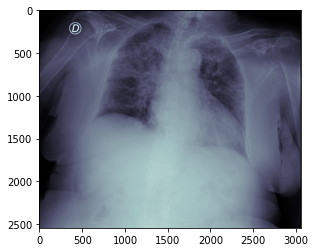

In [8]:
image = dicom2array(t1['file_path'])
plt.imshow(image, cmap=plt.bone())
plt.show()

So we have our test subject, t1. Let's go through the necessary transformations on the image first, then we can do the same to the boxes.

In [9]:
transform = A.Compose([
        A.RandomRotate90(p=0.1),
        A.Flip(p=0.1),
        A.Transpose(p=0.1),
        A.CenterCrop(height=800, width=800, p=0.1),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Resize(height=800, width=800, p=1.0)])

During training, we want random flips vertically, horizontally or both. Followed by some sort of appearance modifier (either brightness contrast or gamma. Alos a shift of the image. These types of transforms will help the model not overfit and also simulate real life variability.

Lastly we want to resize the image to 800 x 800. This will enable faster training.

Let's view some of these changes.

In [10]:
t_image = transform(image=image)['image']

In [11]:
t_image.shape # [H, W]

(800, 800)

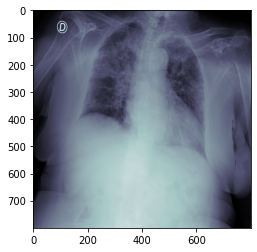

In [12]:
plt.imshow(t_image, cmap=plt.bone())
plt.show()

So now we have our image transformations inplace, it's time to see what the effect is on the bounding boxes.

## Boxes

In [13]:
t1['boxes']

[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214},
 {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]

Currently our boxes are in the format [x, y, width, height] otherwise known as the coco format.

Let's put them in pascal VOC format. To do this we can use [bbox converter](https://albumentations.ai/docs/api_reference/augmentations/bbox_utils/).

In [15]:
rows, cols = image.shape
new_boxes = []
if t1['boxes']:
    for box in t1['boxes']:
        frac_box = (box['x']/cols, box['y']/rows, (box['x']+box['width'])/cols,
                          (box['y']+box['height'])/rows)
        converted = convert_bbox_from_albumentations(bbox=frac_box, 
                                     target_format='pascal_voc', 
                                     rows=rows, cols=cols, 
                                     check_validity=True)
        new_boxes.append(converted)
new_boxes

[(677.42216, 197.97662, 1545.21983, 1197.75876),
 (1792.69064, 402.5525, 2409.71798, 1606.9104999999997)]

Great so we have the bboxes in the required format. Now let's change the transform a little to include these changes to the bounding boxes.

In [32]:
transform = A.Compose([
        A.RandomRotate90(p=0.1),
        A.Flip(p=0.1),
        A.Transpose(p=0.1),
        A.CenterCrop(height=800, width=800, p=0.1),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Resize(height=800, width=800, p=1.0)],
        bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['category_ids']))

# Final Result

In [33]:
BOX_COLOR = (1, 0, 0) # Red

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)  
    return img


def visualize(image, bboxes):
    img = image.copy()
    for box in bboxes:
        img = visualize_bbox(img, box)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

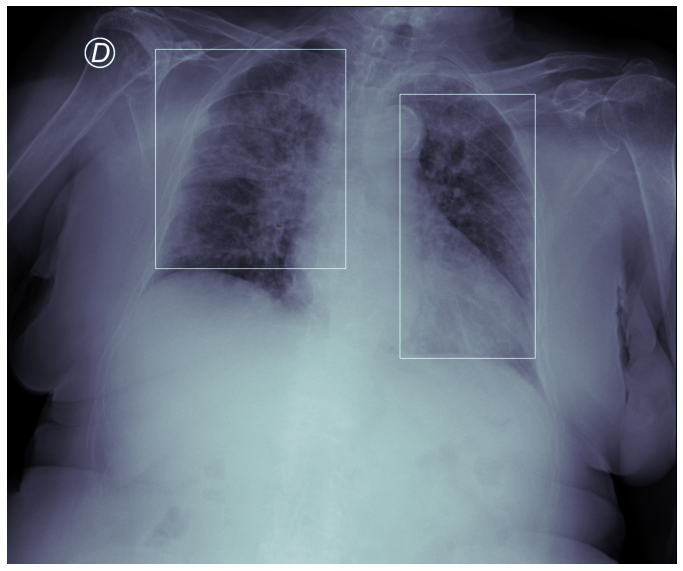

In [34]:
visualize(image=image, bboxes=new_boxes)

The boxes must have labels aswell so we can add that in now.

In [35]:
category_ids = [1, 1]

In [36]:
altered = transform(image=image, bboxes=new_boxes, category_ids=category_ids)

In [37]:
altered.keys()

dict_keys(['image', 'bboxes', 'category_ids'])

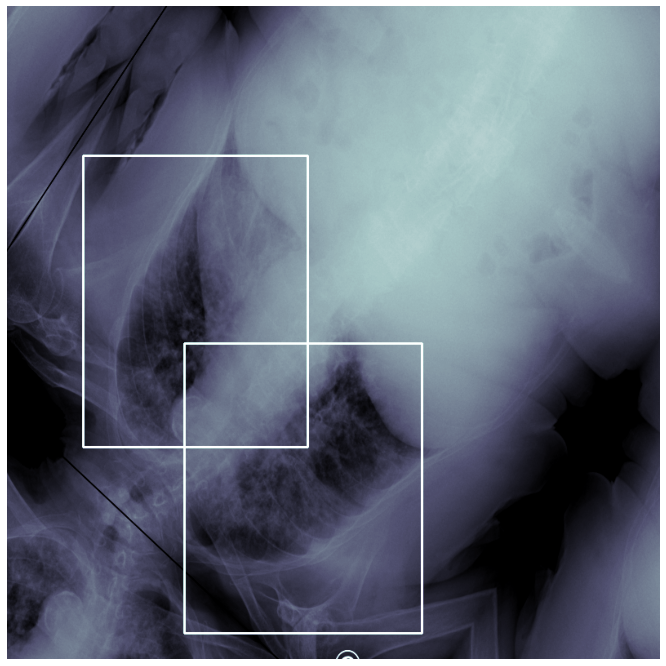

In [38]:
visualize(
    altered['image'],
    altered['bboxes'],
)

Job is a good'n

# Pytorch Dataset

Let's test this in a real scenario.

In [307]:
train_transform = A.Compose([
        A.RandomRotate90(p=0.1),
        A.Flip(p=0.1),
        A.Transpose(p=0.1),
        A.CenterCrop(height=800, width=800, p=0.1),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Resize(height=800, width=800, p=1.0)],
        bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']))

valid_transform = A.Compose([A.Resize(height=800, width=800, p=1.0)], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']))

In [308]:
class SIIM(Dataset):
    def __init__(self, image_ids, df, transforms=None):
        super().__init__()
        # image_ids
        self.image_ids = image_ids
        # random sample data
        self.df = df
        # augmentations
        self.transforms = transforms
    
    def __len__(self) -> int:
        return(len(self.image_ids))
    
    @staticmethod
    def dicom2array(path: str, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        return data.astype(np.float32)
    
    def load_bbox_labels(self, image_id, shape):
        row, col = shape
        records = self.df[self.df['id'] == image_id]
        new_boxes = []
        for boxes in records.boxes.values:
            if boxes:
                for box in boxes:
                    frac_box = (box['x']/cols, box['y']/rows, (box['x']+box['width'])/cols,
                                      (box['y']+box['height'])/rows)
                    converted = convert_bbox_from_albumentations(bbox=frac_box, 
                                                 target_format='pascal_voc', 
                                                 rows=rows, cols=cols, 
                                                 check_validity=True)
                    new_boxes.append(converted)
        labels = [records['integer_label'].values[0]] * len(boxes)
        return(new_boxes, labels)
        
    def __getitem__(self, idx: int):
        # retrieve idx data
        image_id = self.image_ids[idx]
        # get path
        image_path = self.df[self.df['id'] == image_id].file_path.values[0]
        # get image
        image = self.dicom2array(image_path)
        # get boxes and labels
        boxes, labels = self.load_bbox_labels(image_id, image.shape)
        if self.transforms:
            tform = self.transforms(image=image, 
                              bboxes=boxes, 
                              labels=labels)
            image = tform['image']
            target = {'boxes': torch.tensor(tform['bboxes']), 
                      'labels': torch.tensor(tform['labels'])}
            # 1 Channel vs 3 Channel?
            image = np.dstack((image, image, image))
            return(torch.tensor(image).permute(2, 0, 1), target, image_id)
            
        return image, boxes, image_id

In [309]:
train_ids = train[train.fold!=3].id.values

In [315]:
dataset = SIIM(image_ids=train_ids, df=train, transforms=train_transform)

In [316]:
image, target, image_id = dataset[2]

In [317]:
image.shape

torch.Size([3, 800, 800])

In [318]:
target

{'boxes': tensor([[221.7071,   0.0000, 549.6382, 340.6695],
         [456.4437, 133.7531, 744.0017, 578.4487]], dtype=torch.float64),
 'labels': tensor([1, 1])}

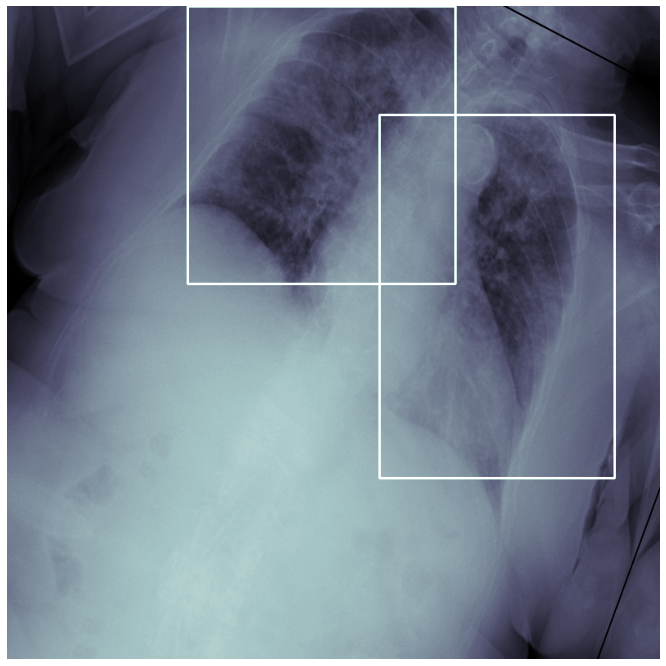

In [319]:
visualize(image.numpy()[0,:,:], target['boxes'].numpy())

That should do it, now we can use this new dataset to output a three channel, for CNN.